In [1]:
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
from data_preprocessing import *

In [3]:
apartments = pd.read_csv('data/apartments_train.csv')
print(f'Loaded {len(apartments)} apartments')
with open('data/apartments_meta.json') as f: 
    apartments_meta = json.load(f)
describe_data(apartments, apartments_meta)

Loaded 23285 apartments


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID for apartment,#unique=23285
seller,categorical,8830,The type of apartment seller,"Agents(1895), Company(4768), Developer(6185), Owner(1607)"
price,real,0,The listed price of the apartment (TARGET),"mean=23556173.5, std=52643927.8, min=900000.0, max=2600000000.0"
area_total,real,0,Total area of the apartment,"mean=74.5, std=58.7, min=9.3, max=2181.0"
area_kitchen,real,4721,Total kitchen area in the apartment,"mean=12.6, std=6.6, min=1.0, max=100.0"
area_living,real,3882,Total living space area in the apartment,"mean=38.7, std=31.4, min=0.0, max=900.0"
floor,integer,0,Primary building floor of the apartment,"mean=9.0, std=8.3, min=1.0, max=95.0"
rooms,integer,0,Number of rooms in the apartment,"mean=2.2, std=1.1, min=1.0, max=6.0"
layout,categorical,17642,Overal apartment layout,"Adjacent(241), Adjacent_isolated(465), Isolated(4937)"
ceiling,real,11093,Ceiling height in the apartment,"mean=3.3, std=10.8, min=0.0, max=340.0"


In [4]:
buildings = pd.read_csv('data/buildings_train.csv')
print(f'Loaded {len(buildings)} buildings')
with open('data/buildings_meta.json') as f: 
    buildings_meta = json.load(f)
buildings.head()
describe_data(buildings, buildings_meta)

Loaded 6791 buildings


,Type,#NaN,Description,Statistics
id,integer_id,0,Unique ID of building for joining with apartments,#unique=6791
new,boolean,227,Whether it is an old or new building,"False(6141), True(423)"
latitude,real,0,Latitude coordinate of building,"mean=55.7, std=0.1, min=55.2, max=56.0"
longitude,real,0,Longitude coordinate of building,"mean=37.6, std=0.2, min=36.9, max=38.0"
district,categorical,1,Administriative district within Moscow,"Central(637), East(956), North(593), North-East(630), North-West(553), Novomoskovsk(344), South(758), South-East(672), South-West(900), Troitsk(146), West(535), Zelenograd(66)"
street,string,0,Bulding street name,#unique=1682
address,string,0,Building address (within street),#unique=1851
constructed,integer,479,Year when the building was constructed,"mean=1985.8, std=24.3, min=1855.0, max=2023.0"
material,categorical,1165,Primary building material used in building,"Block(679), Bricks(1226), Monolith(1312), Monolithic_brick(19), Panel(2384), Stalin_project(2), Wood(4)"
stories,integer,0,Total number of floors in the building,"mean=13.0, std=7.0, min=1.0, max=95.0"


In [5]:
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data.head()

All apartments have an associated building: True


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [6]:
from evaluation_metric import *

In [7]:
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
print(f'Number of train samples: {len(data)}')
print(f'Number of test samples:  {len(data_test)}')
data_test.head()

All test apartments have an associated building: True
Number of train samples: 23285
Number of test samples:  9937


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,...,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,...,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,...,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,...,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,...,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


Number of missing price entries in train data: 0
Training set features with any missing value: 23/34
Testing set features with any missing value: 25/33


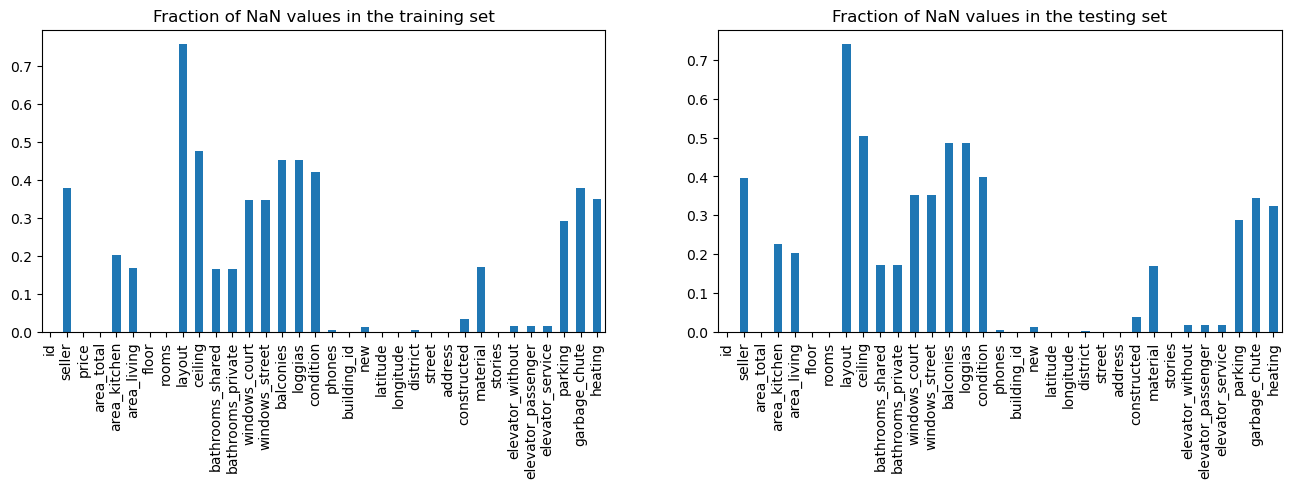

In [8]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data.price.isna().sum()}')
print(f'Training set features with any missing value: {data.isna().any().sum()}/{data.shape[1]}')
print(f'Testing set features with any missing value: {data_test.isna().any().sum()}/{data_test.shape[1]}')
data.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

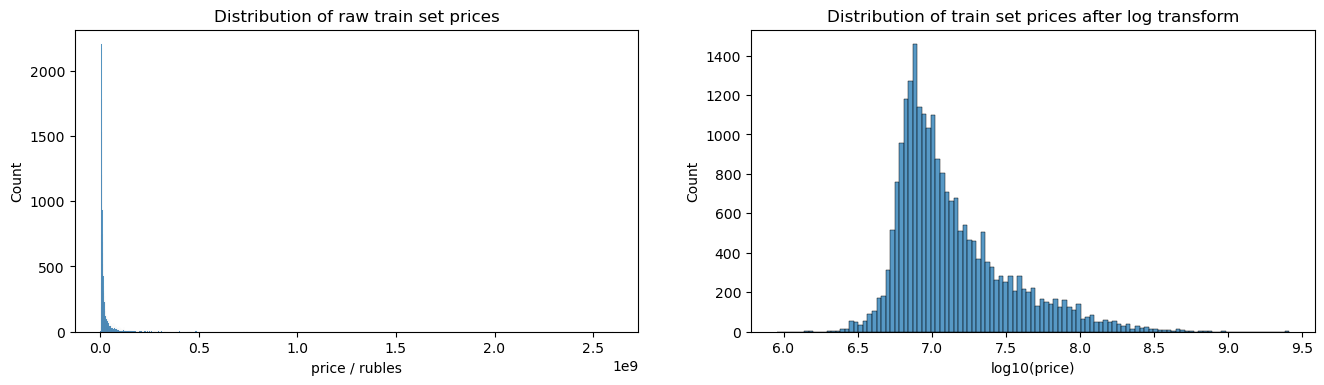

In [9]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(data.price.rename('price / rubles'), ax=ax1)
ax1.set_title('Distribution of raw train set prices');
sns.histplot(np.log10(data.price).rename('log10(price)'), ax=ax2)
ax2.set_title('Distribution of train set prices after log transform');

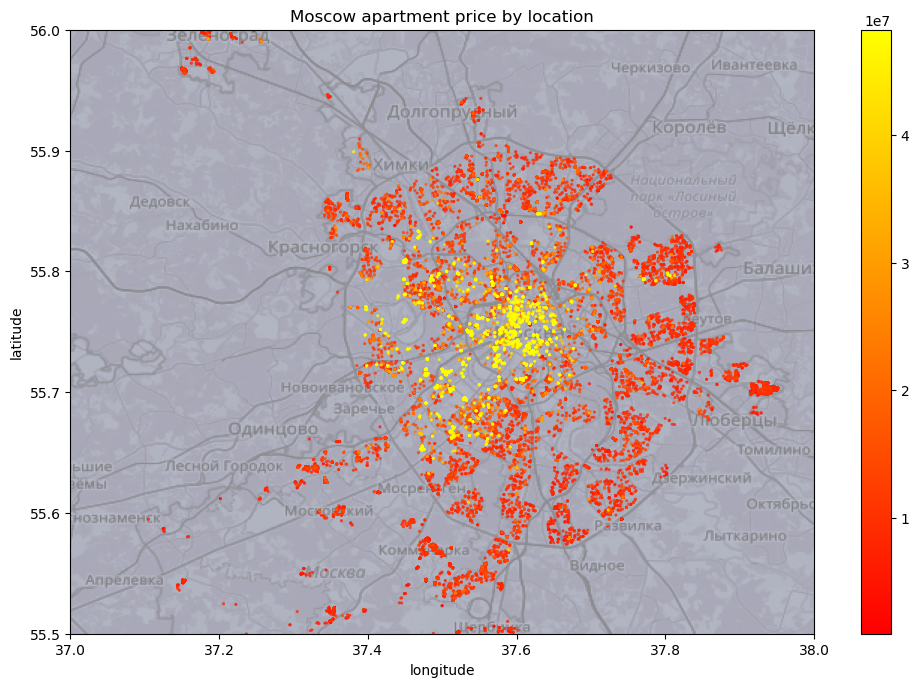

In [10]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(data);


Split dataset into 15600 training samples and 7685 validation samples


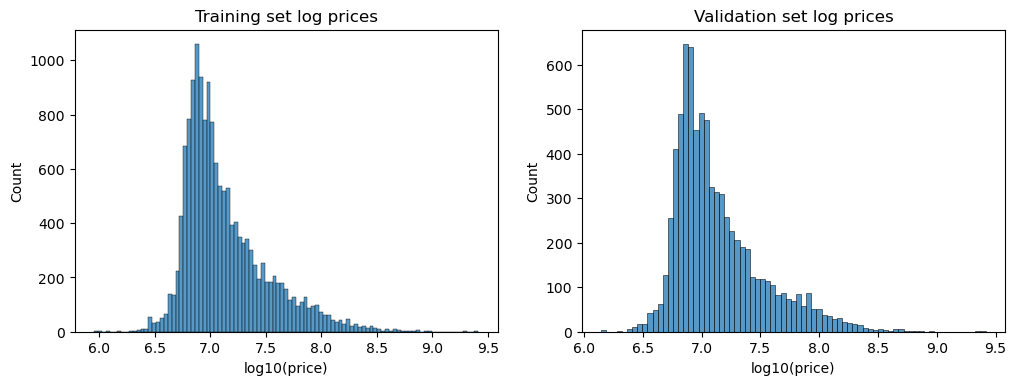

In [11]:
import sklearn.model_selection as model_selection

data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, dpi=100)
print(f'Split dataset into {len(data_train)} training samples and {len(data_valid)} validation samples')

sns.histplot(np.log10(data_train.price).rename('log10(price)'), ax=ax1);
sns.histplot(np.log10(data_valid.price).rename('log10(price)'), ax=ax2);
ax1.set_title('Training set log prices'); ax2.set_title('Validation set log prices');

In [12]:
y_train = data_train.price
y_valid = data_valid.price

mean = y_train.mean()
y_train_hat = np.full(len(y_train), mean)
y_valid_hat = np.full(len(y_valid), mean)

print(f'Train rmsle: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

Train rmsle: 1.0192
Valid rmsle: 1.0211


Train RMSLE: 0.2767
Valid RMSLE: 0.4258


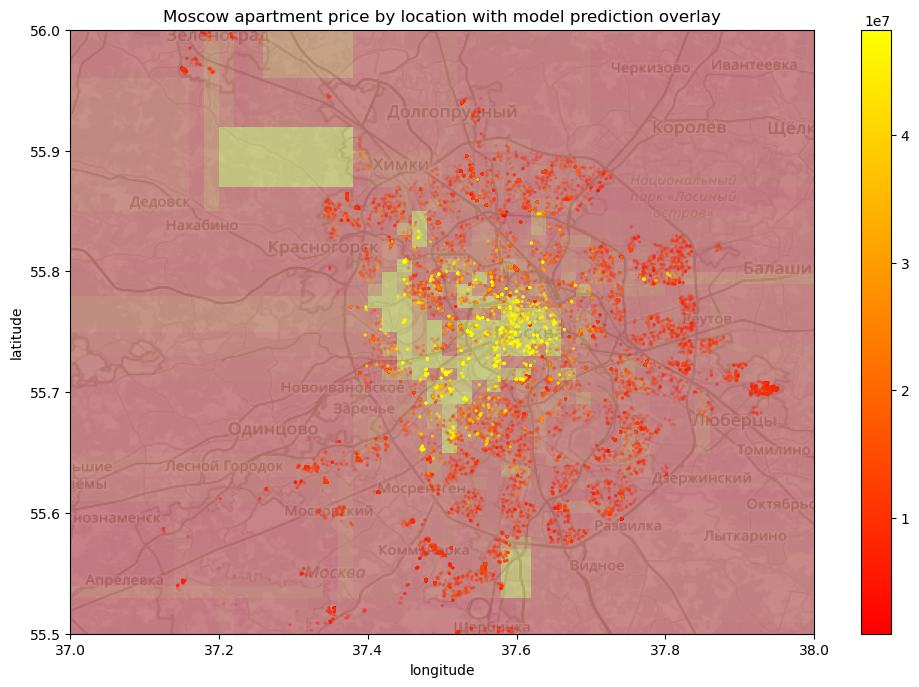

In [13]:
import sklearn.tree as tree

X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price

model = tree.DecisionTreeRegressor().fit(X_train, y_train)

y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
print(f'Train RMSLE: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid RMSLE: {root_mean_squared_log_error(y_true=y_valid, y_pred=y_valid_hat) :.4f}')

lats, lngs = np.meshgrid(np.linspace(55.5, 56, 50), np.linspace(37, 38, 50))
preds = model.predict(np.stack([lats, lngs], axis=-1).reshape(-1, 2)).reshape(lats.shape)
ax, norm = plot_map(data, a=0.25)
ax.set_title(ax.get_title() + ' with model prediction overlay')
ax.imshow(preds.T[::-1, :], extent=(37, 38, 55.5, 56), alpha=0.3, aspect='auto', cmap='autumn', norm=norm);

In [14]:
X_train = data[['latitude', 'longitude']]
y_train = data['price']
print(f'Num nans in train {X_train.isna().any(axis=1).sum()}')
model = tree.DecisionTreeRegressor(max_depth=20).fit(X_train, y_train)

# Generate predictions for test set 
X_test = data_test[['latitude', 'longitude']]
X_test_nan = X_test.isna().any(axis=1)
print(f'Num nans in test: {X_test_nan.sum()}')
y_test_hat = model.predict(X_test[~X_test_nan])

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = data_test.id
submission.loc[~X_test_nan, 'price_prediction'] = y_test_hat # Predict on non-nan entries
submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor
print(f'Generated {len(submission)} predictions')

# Export submission to csv with headers
submission.to_csv('sample_submission.csv', index=False)

# Look at submitted csv
print('\nLine count of submission')
!wc -l sample_submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 sample_submission.csv

Num nans in train 0
Num nans in test: 2
Generated 9937 predictions

Line count of submission

First 5 rows of submission


'wc' is not recognized as an internal or external command,
operable program or batch file.
'head' is not recognized as an internal or external command,
operable program or batch file.
